# Comparative EDA: Mud Pump A vs Mud Pump B
This notebook compares the operational data of Mud Pump A and Mud Pump B.
It analyzes data at different granularities (Hourly vs Daily) and explores distributions and trends for **ALL** available features.

**Goal:** Compare performance and stability of the two pumps across all sensors.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
pd.set_option('display.max_columns', None)



In [2]:
# Load Datasets
try:
    df_a = pd.read_csv('datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
    df_b = pd.read_csv('datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])
    print("Data loaded successfully.")
    print(f"Pump A Shape: {df_a.shape}")
    print(f"Pump B Shape: {df_b.shape}")
except FileNotFoundError:
    print("Error: Datasets not found in 'datasets/' directory.")



/tmp/ipykernel_17240/2263913332.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_a = pd.read_csv('datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
/tmp/ipykernel_17240/2263913332.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_b = pd.read_csv('datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])


Data loaded successfully.
Pump A Shape: (8785, 14)
Pump B Shape: (8785, 13)


In [3]:
# Standardize Column Names for Comparison
# We want to map as many columns as possible to a common schema.

def standardize_columns(df, pump_prefix):
    df_clean = df.copy()
    
    # 1. Explicit Mapping (Known shared columns)
    # Map specific variations to standard names
    mapping = {
        # Pressure
        'MUD PUMP A SUCTION PRESS': 'Suction Pressure',
        'MUD PUMP B SLEECTED PRESSURE': 'Suction Pressure',
        
        # Current
        'PUM-34A- Current': 'Current',
        'Mud Pump B Current': 'Current',
        
        # Speed (Handle duplicates later, just map the main ones if distinct)
        # 'MUD PUMP A SPEED': 'Speed', # Often duplicates, handled by generic cleaner or specific selection
    }
    
    df_clean.rename(columns=mapping, inplace=True)
    
    # 2. Generic Cleaning
    # Remove Pump Prefixes to align names like "Mud Pump A Cylinder #1 Temperature" -> "Cylinder #1 Temperature"
    new_cols = []
    for col in df_clean.columns:
        new_name = col
        
        # Remove specific pump prefixes (case insensitive)
        prefixes = [f"MUD PUMP {pump_prefix} ", f"Mud Pump {pump_prefix} ", f"Mud pump {pump_prefix} "]
        for p in prefixes:
            if new_name.upper().startswith(p.upper()):
                new_name = new_name[len(p):] # Strip prefix
                
        # Clean up extra spaces or specific artifacts
        new_name = new_name.replace("Cylinder #", "Cylinder ").replace("CYLINDER ", "Cylinder ")
        
        # Capitalize nicely
        new_name = new_name.strip()
        
        new_cols.append(new_name)
        
    df_clean.columns = new_cols
    
    # 3. Handle Duplicate Columns (e.g. Speed appearing twice)
    # We will keep the first occurrence of any duplicate column name
    df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
    
    # Add Pump Identifier
    df_clean['Pump'] = f'Pump {pump_prefix}'
    
    return df_clean

df_a_clean = standardize_columns(df_a, 'A')
df_b_clean = standardize_columns(df_b, 'B')

# Identify Common Columns (Intersection)
common_cols = list(set(df_a_clean.columns) & set(df_b_clean.columns))
# Ensure Datetime and Pump are included (they should be)
if 'Datetime' not in common_cols: common_cols.append('Datetime')
if 'Pump' not in common_cols: common_cols.append('Pump')

# Sort columns for consistency
common_cols = sorted(common_cols)

# Filter to common columns for direct comparison
df_a_common = df_a_clean[common_cols]
df_b_common = df_b_clean[common_cols]

print(f"Common Columns found: {len(common_cols)}")
print(common_cols)

# Combine
df_combined = pd.concat([df_a_common, df_b_common], ignore_index=True)
df_combined.head()



Common Columns found: 11
['Current', 'Cylinder 1 Temperature', 'Cylinder 2 Temperature', 'Cylinder 3', 'Cylinder 3 Temperature', 'Cylinder 4 Temperature', 'Datetime', 'Pump', 'SPEED', 'SPEED.1', 'Suction Pressure']


Current  Cylinder 1 Temperature  Cylinder 2 Temperature  Cylinder 3  \
0  262.89                   62.21                   52.91     6795.82   
1  268.08                   61.64                   51.34     7035.89   
2  265.45                   61.43                   52.12     6843.67   
3  270.20                   61.10                   49.37     6951.88   
4  269.51                   61.52                   50.28     6958.68   

   Cylinder 3 Temperature  Cylinder 4 Temperature            Datetime    Pump  \
0                   59.37                   57.87 2024-09-03 00:00:00  Pump A   
1                   59.75                   58.15 2024-09-03 01:00:00  Pump A   
2                   60.37                   58.98 2024-09-03 02:00:00  Pump A   
3                   59.97                   58.11 2024-09-03 03:00:00  Pump A   
4                   61.68                   58.28 2024-09-03 04:00:00  Pump A   

   SPEED  SPEED.1  Suction Pressure  
0  42.00    99.40            387.84  
1  42.05    99.32            434.91  
2  41.96    99.47            424.09  
3  42.01    99.36            423.87  
4  41.95    99.50            425.91

## Comparative Statistics
Side-by-side descriptive statistics for **ALL** shared numeric features.



In [4]:
# Group by Pump and describe all numeric columns
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
stats = df_combined.groupby('Pump')[numeric_cols].describe().T
stats



Pump                               Pump A       Pump B
Cylinder 1 Temperature count  8785.000000  8785.000000
                       mean     49.774731    39.721980
                       std      17.329280    16.687432
                       min       3.520000     3.740000
                       25%      52.710000    19.500000
                       50%      57.760000    48.520000
                       75%      59.870000    52.180000
                       max      86.100000    77.710000
Cylinder 2 Temperature count  8785.000000  8785.000000
                       mean     46.389478    36.546890
                       std      16.075967    14.915961
                       min       3.560000     3.080000
                       25%      46.490000    19.190000
                       50%      52.590000    44.060000
                       75%      57.200000    47.710000
                       max      85.480000    78.070000
Cylinder 3             count  8785.000000  8785.000000
                       mean   4922.955725  4275.195788
                       std    2661.930512  3023.319884
                       min     -22.750000   -65.440000
                       25%    4171.520000    20.600000
                       50%    6202.850000  5806.590000
                       75%    6834.950000  6845.030000
                       max    8492.530000  8350.690000
Cylinder 3 Temperature count  8785.000000  8785.000000
                       mean     46.677751    38.637291
                       std      15.974275    16.395684
                       min       4.230000     3.990000
                       25%      48.870000    19.070000
                       50%      53.180000    47.340000
                       75%      56.320000    50.350000
                       max      88.500000    75.080000
Cylinder 4 Temperature count  8785.000000  8785.000000
                       mean     45.255169    35.710018
                       std      15.346964    15.083405
                       min       3.860000     3.910000
                       25%      47.490000    18.790000
                       50%      52.110000    41.620000
                       75%      54.560000    47.340000
                       max      82.540000    64.560000
SPEED.1                count  8785.000000  8785.000000
                       mean     91.024974    61.967653
                       std      21.741351    46.418265
                       min      -5.000000    -5.000000
                       25%      94.870000    -5.000000
                       50%      99.380000    91.500000
                       75%      99.730000    99.050000
                       max     100.000000   100.000000
Suction Pressure       count  8785.000000  8785.000000
                       mean    339.738274  4923.025183
                       std     185.737520  2661.848628
                       min      -2.810000   -22.500000
                       25%     280.440000  4174.150000
                       50%     394.050000  6201.750000
                       75%     466.420000  6835.130000
                       max     629.900000  8572.170000

## Distributions
Overlaid histograms/KDEs for **ALL** shared numeric features.



Plotting distribution for: Cylinder 1 Temperature


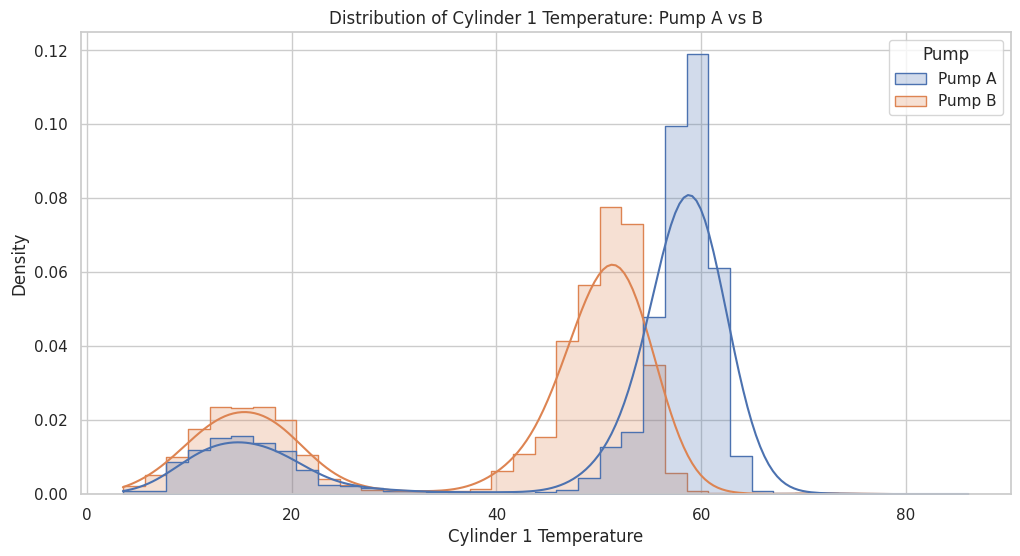

Plotting distribution for: Cylinder 2 Temperature


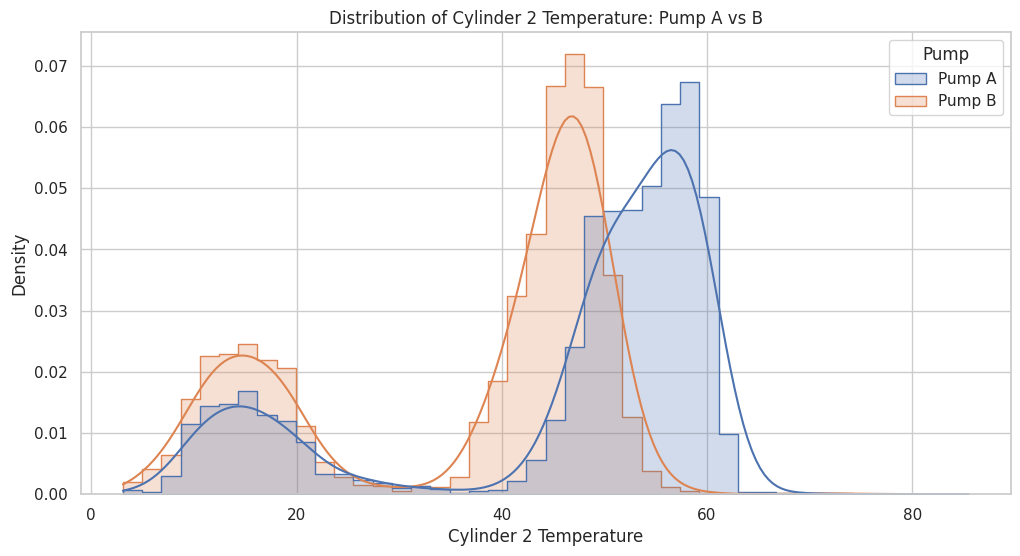

Plotting distribution for: Cylinder 3


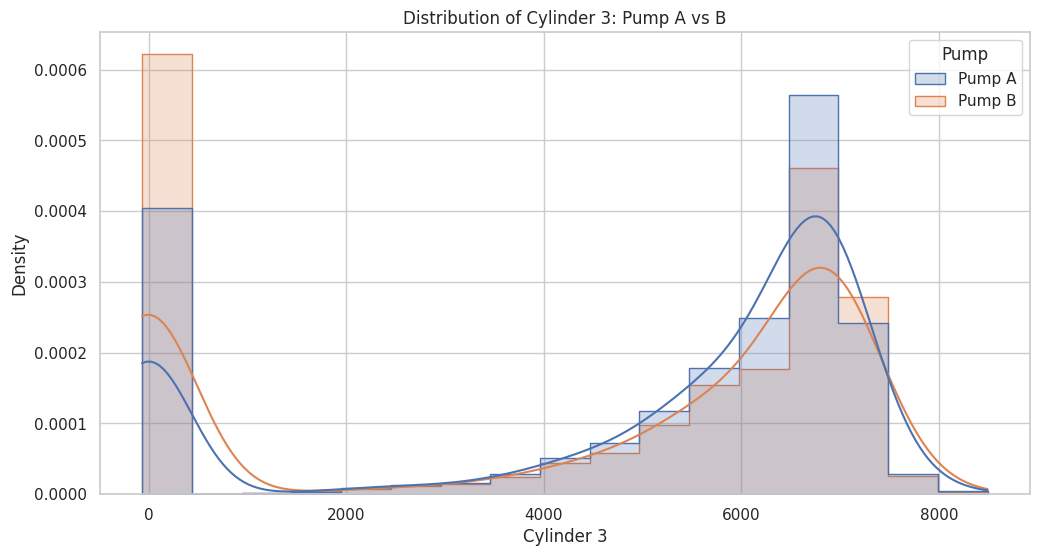

Plotting distribution for: Cylinder 3 Temperature


Plotting distribution for: Cylinder 4 Temperature


Plotting distribution for: SPEED.1


Plotting distribution for: Suction Pressure


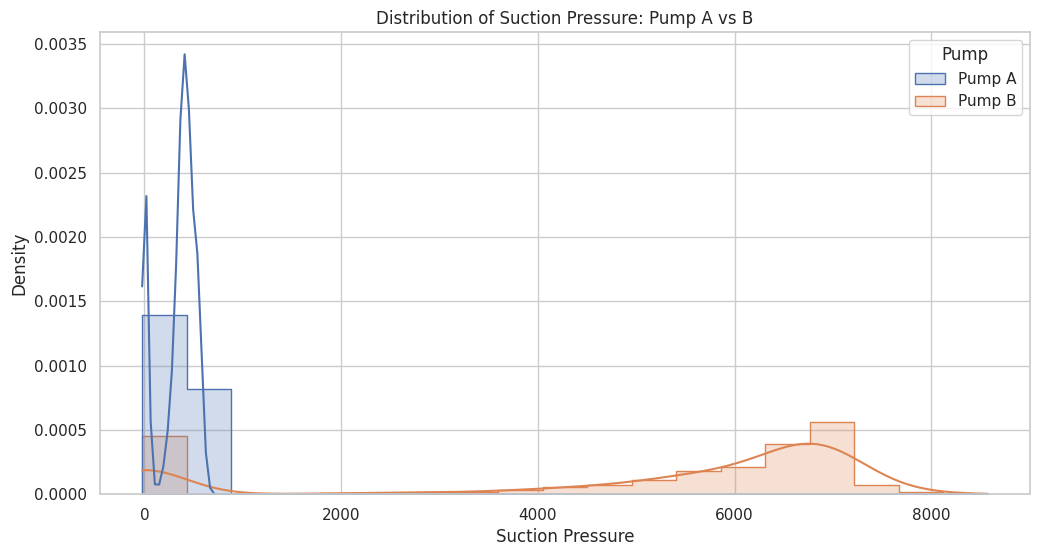

In [5]:
def plot_distribution(feature):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_combined, x=feature, hue='Pump', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {feature}: Pump A vs B')
    plt.show()

# Loop through all numeric columns (excluding 'Pump' if it was somehow numeric, but it's str)
for col in numeric_cols:
    print(f"Plotting distribution for: {col}")
    plot_distribution(col)



## Granularity Analysis
Comparing raw **Hourly** data vs aggregated **Daily** data for **ALL** features.



--- Granularity Analysis: Cylinder 1 Temperature ---


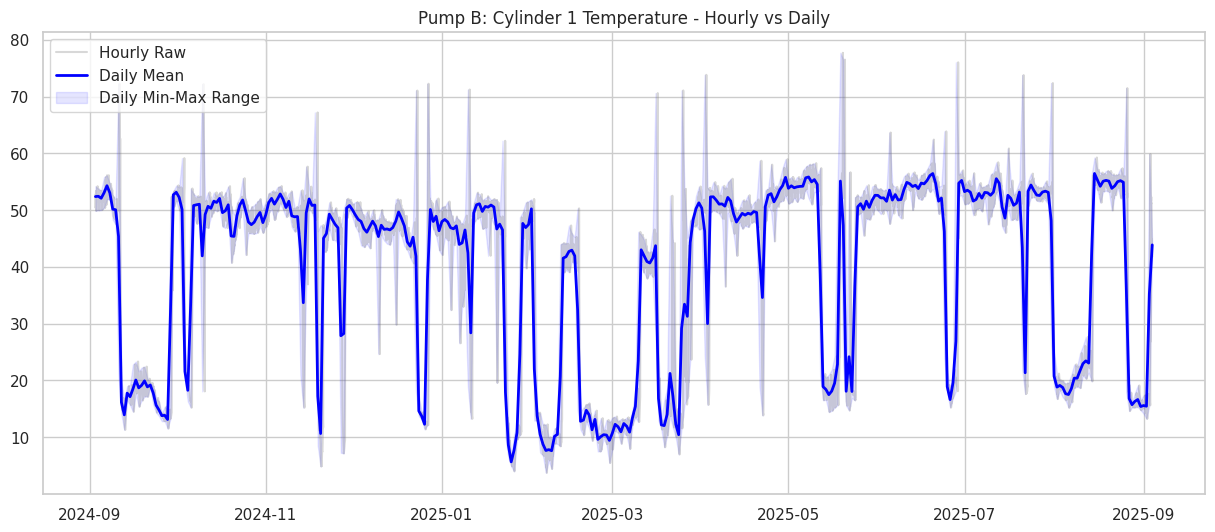

--- Granularity Analysis: Cylinder 2 Temperature ---


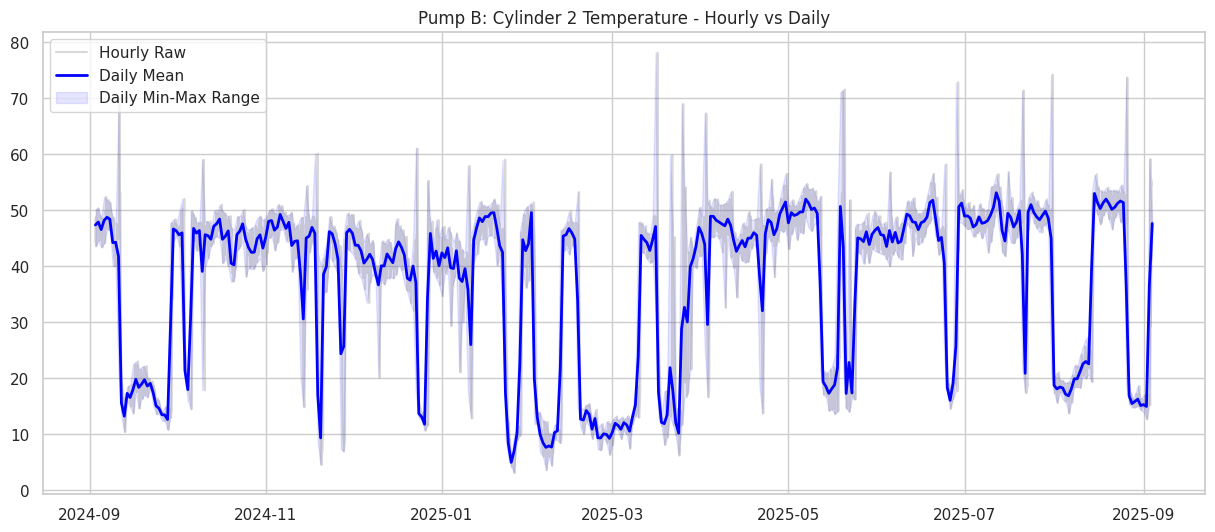

--- Granularity Analysis: Cylinder 3 ---


--- Granularity Analysis: Cylinder 3 Temperature ---


--- Granularity Analysis: Cylinder 4 Temperature ---


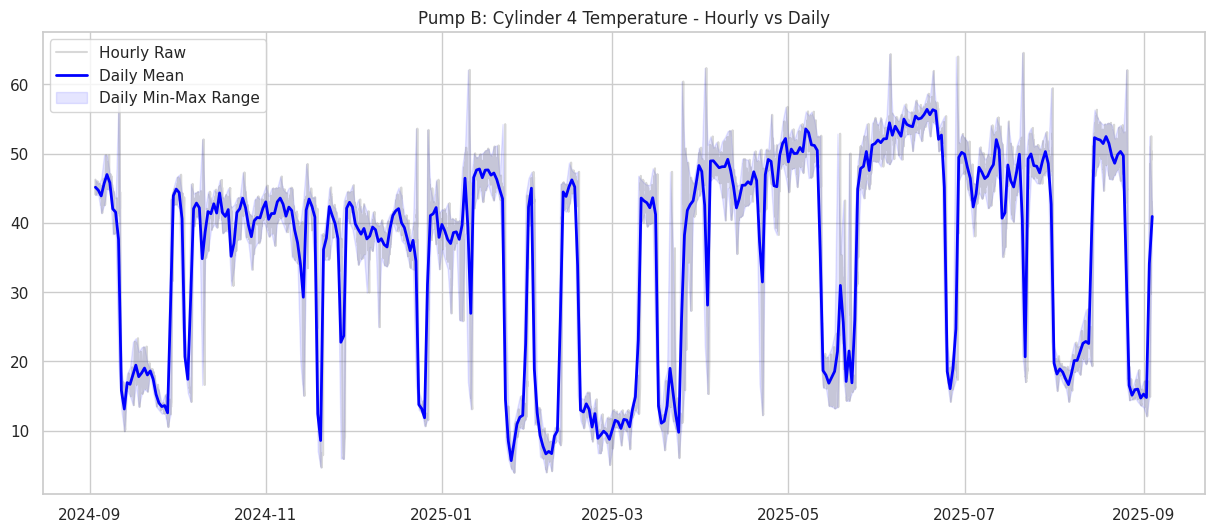

--- Granularity Analysis: SPEED.1 ---


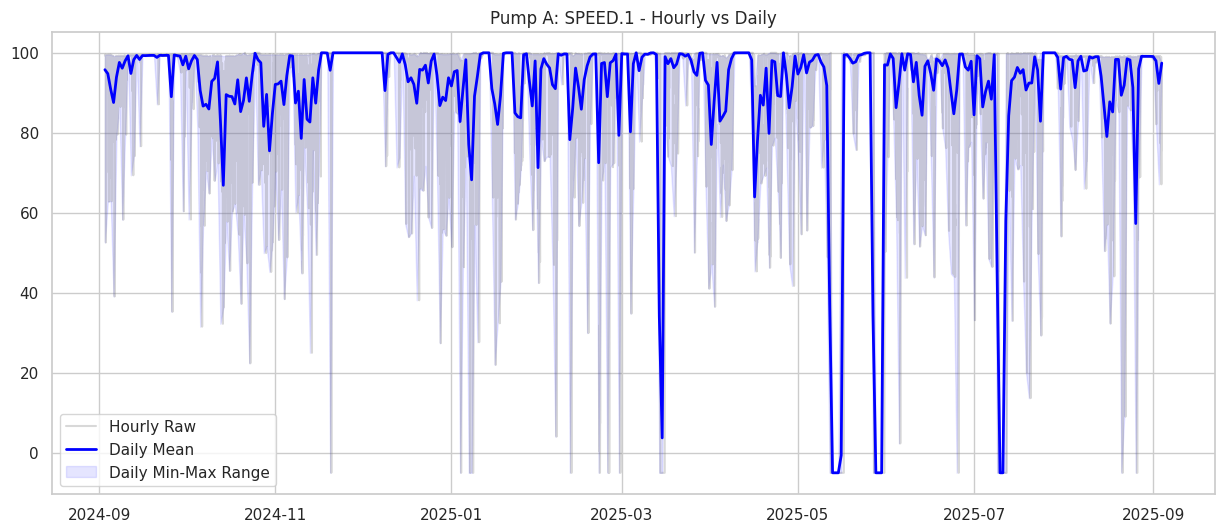

--- Granularity Analysis: Suction Pressure ---


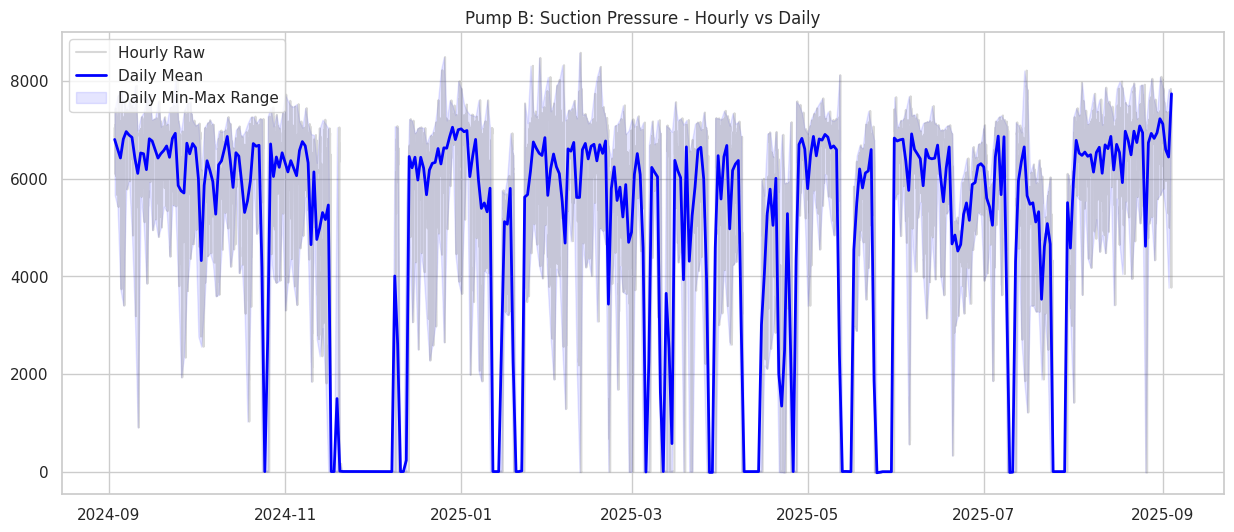

In [6]:
def plot_granularity(df, pump_name, feature):
    df_pump = df[df['Pump'] == pump_name].set_index('Datetime').sort_index()
    
    # Resample to Daily
    df_daily = df_pump[feature].resample('D').agg(['mean', 'min', 'max'])
    
    plt.figure(figsize=(15, 6))
    
    # Plot Raw Hourly (alpha for transparency)
    plt.plot(df_pump.index, df_pump[feature], label='Hourly Raw', alpha=0.3, color='gray')
    
    # Plot Daily Mean
    plt.plot(df_daily.index, df_daily['mean'], label='Daily Mean', color='blue', linewidth=2)
    
    # Plot Daily Min/Max Range
    plt.fill_between(df_daily.index, df_daily['min'], df_daily['max'], color='blue', alpha=0.1, label='Daily Min-Max Range')
    
    plt.title(f'{pump_name}: {feature} - Hourly vs Daily')
    plt.legend()
    plt.show()

# Loop through features and pumps
for col in numeric_cols:
    print(f"--- Granularity Analysis: {col} ---")
    plot_granularity(df_combined, 'Pump A', col)
    plot_granularity(df_combined, 'Pump B', col)



## Rolling Statistics (Stability Trends)
Calculating 24-hour rolling mean and standard deviation for **ALL** features.



--- Rolling Stats: Cylinder 1 Temperature ---


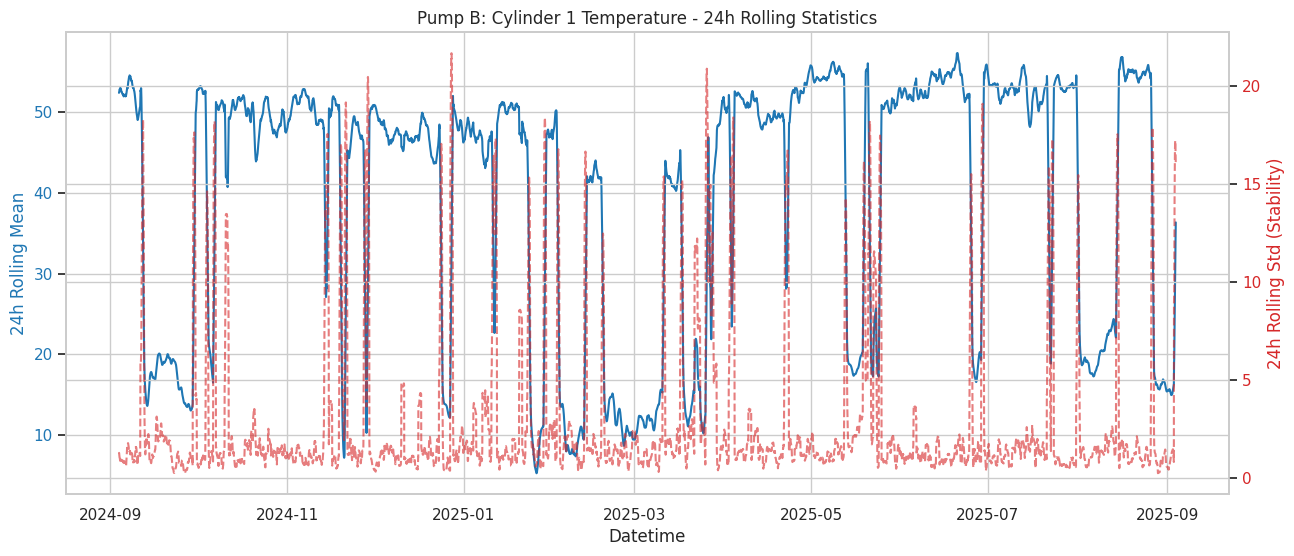

--- Rolling Stats: Cylinder 2 Temperature ---


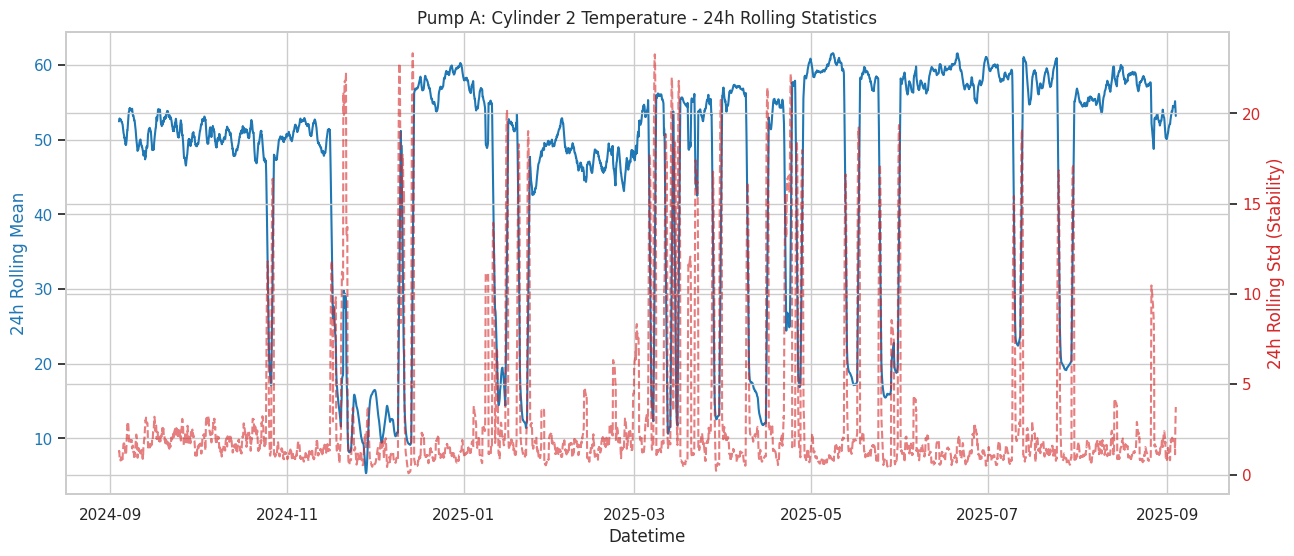

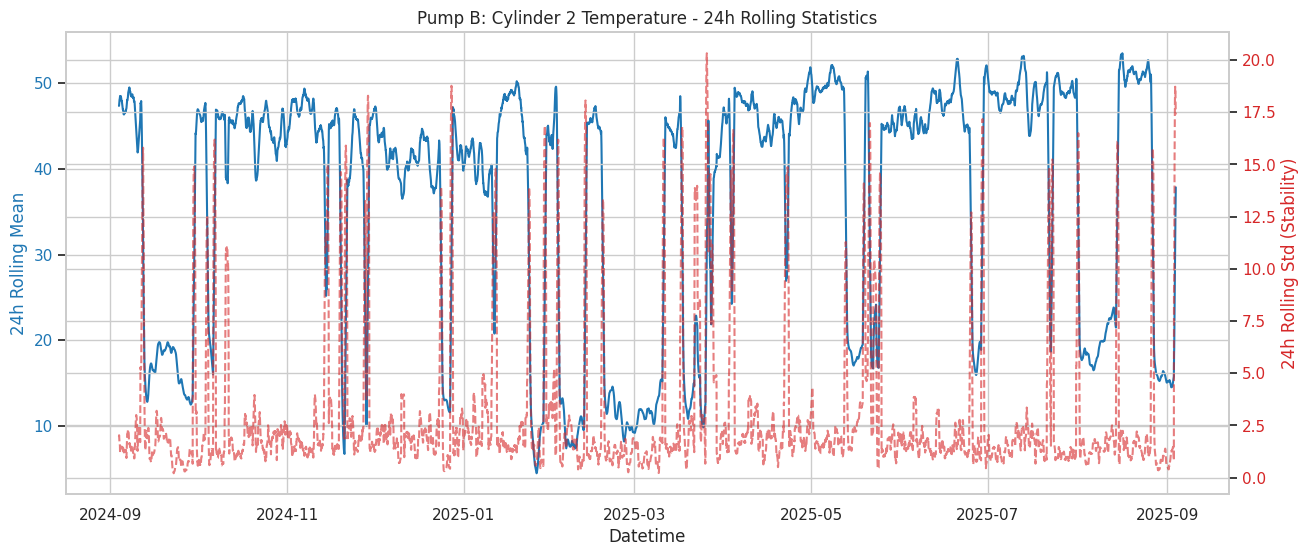

--- Rolling Stats: Cylinder 3 ---


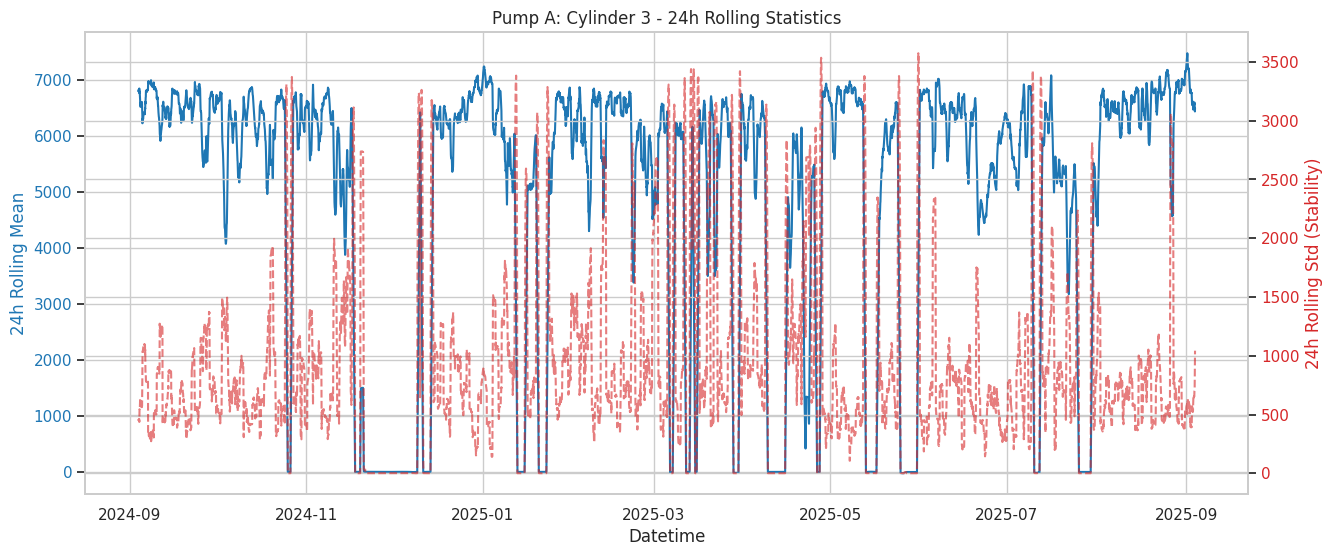

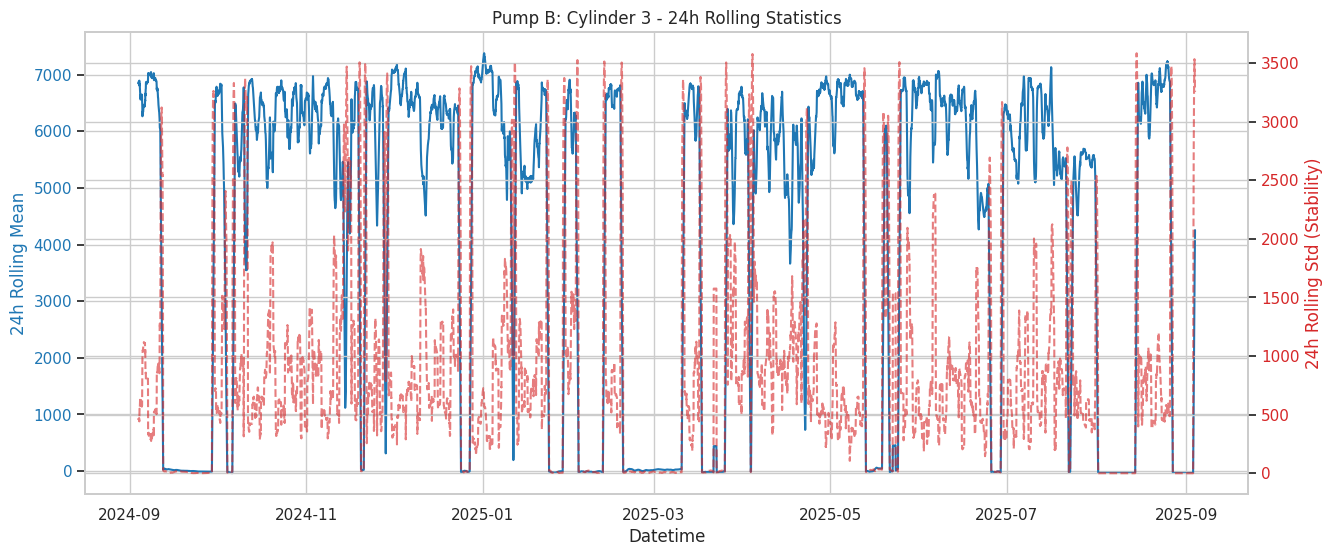

--- Rolling Stats: Cylinder 3 Temperature ---


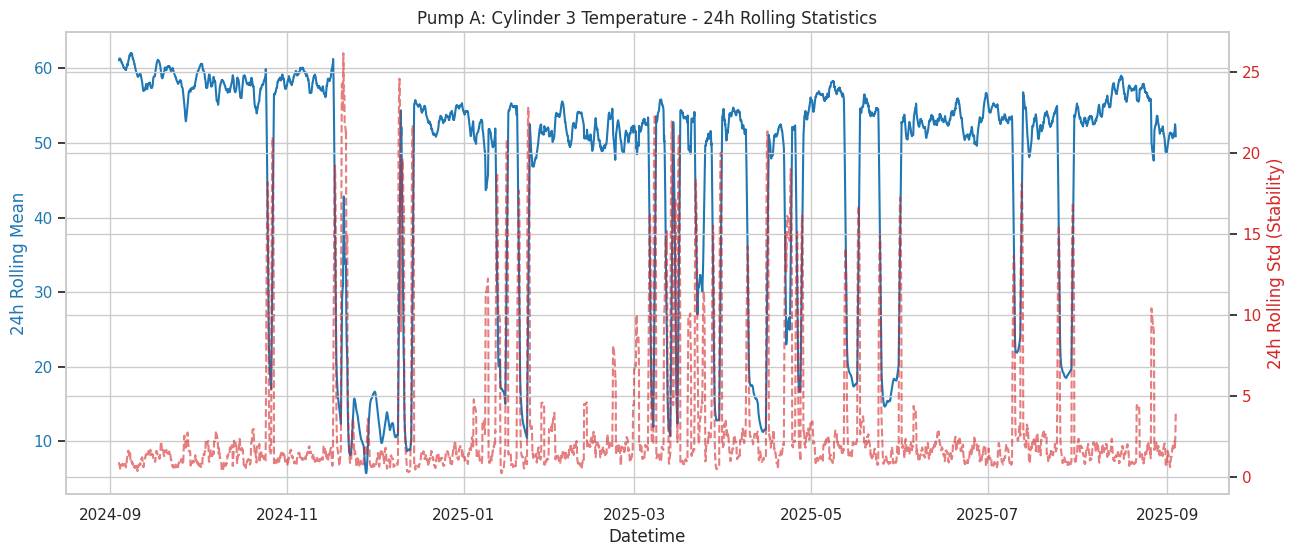

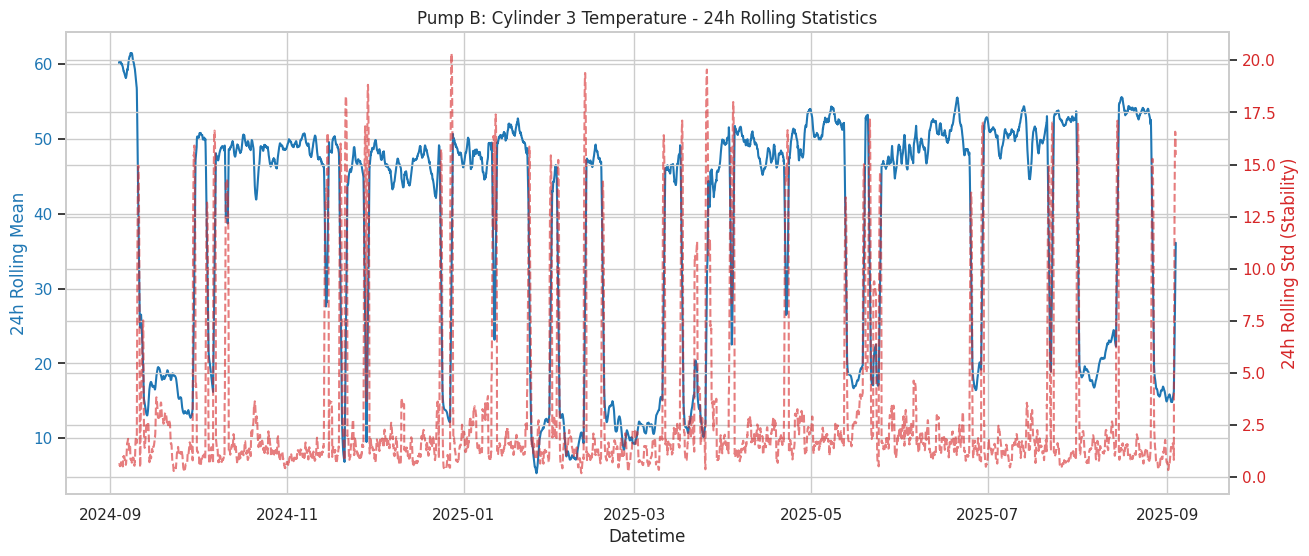

--- Rolling Stats: Cylinder 4 Temperature ---


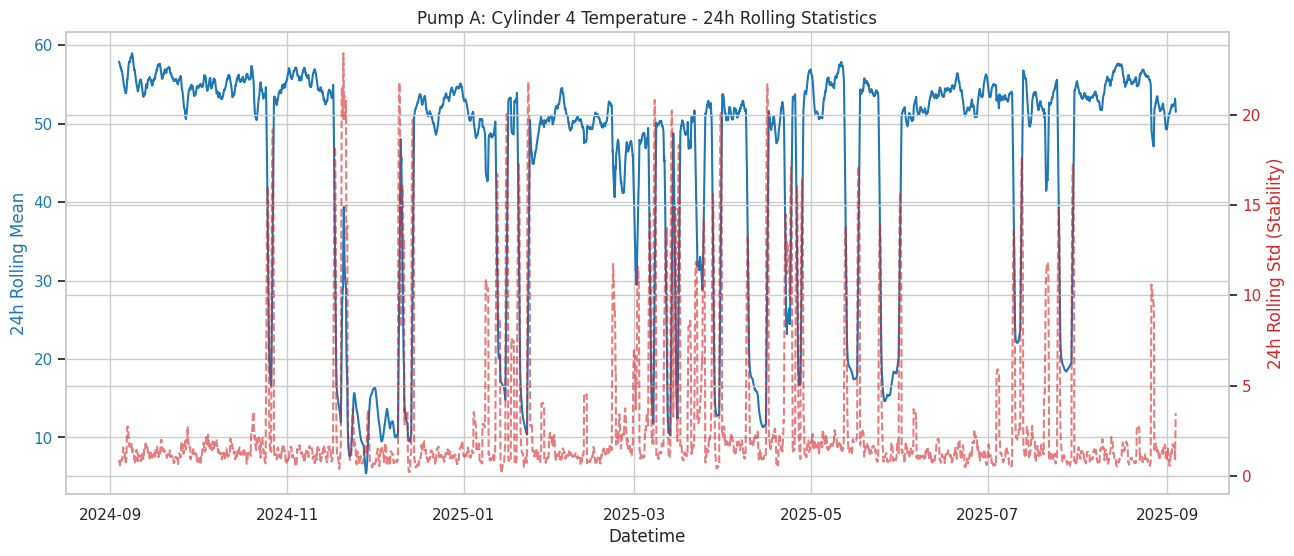

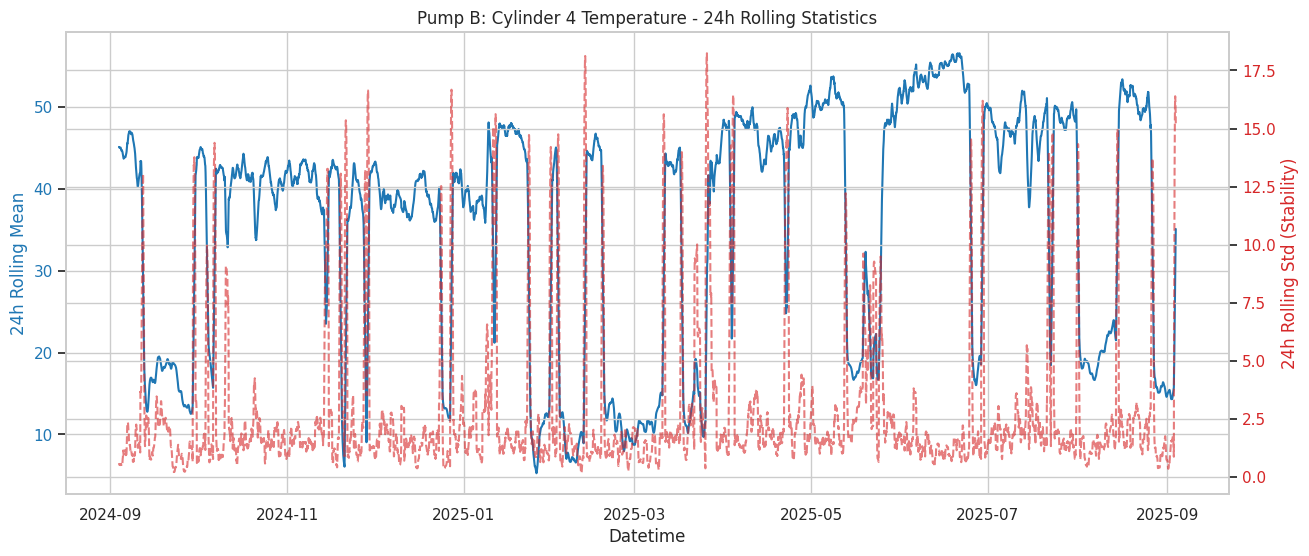

--- Rolling Stats: SPEED.1 ---


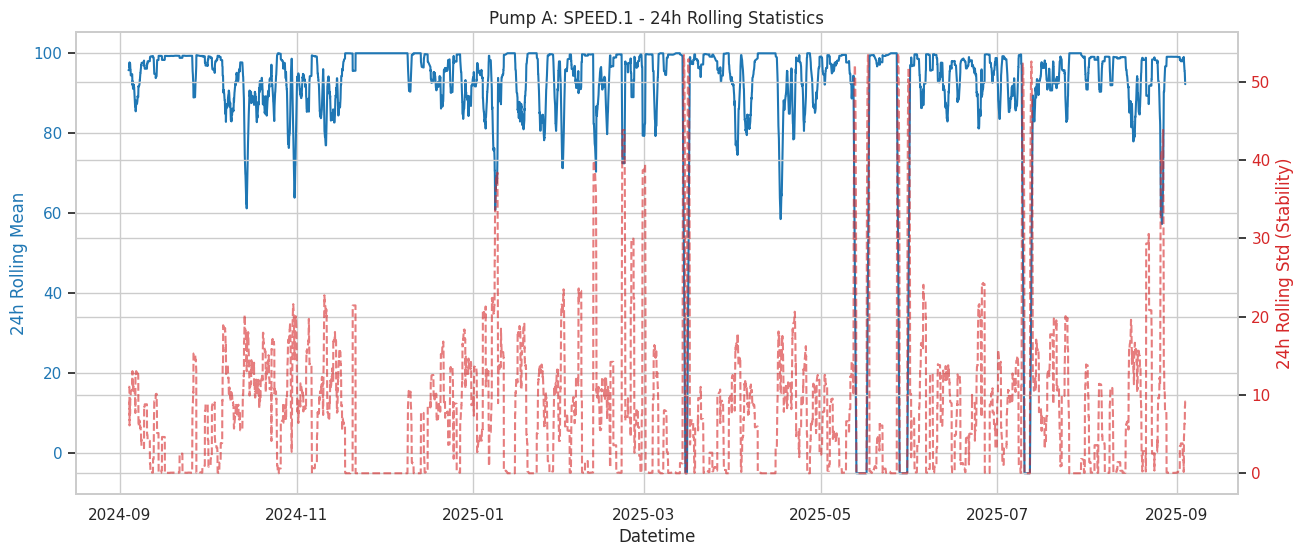

--- Rolling Stats: Suction Pressure ---


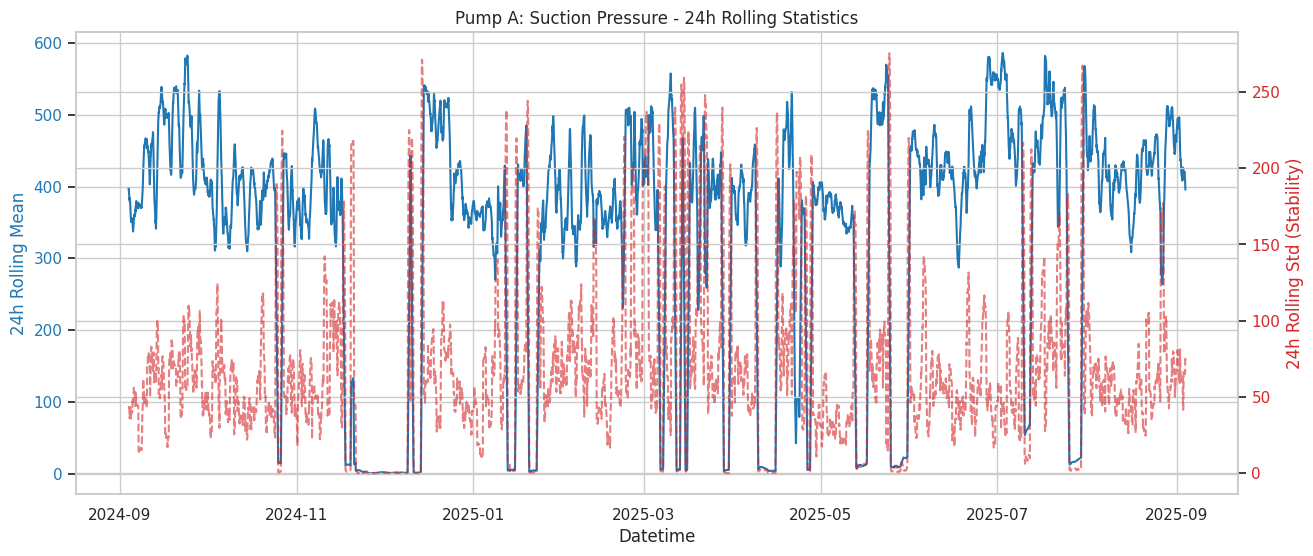

In [7]:
def plot_rolling(df, pump_name, feature, window=24):
    df_pump = df[df['Pump'] == pump_name].set_index('Datetime').sort_index()
    
    # Rolling calcs
    rolling_mean = df_pump[feature].rolling(window=window).mean()
    rolling_std = df_pump[feature].rolling(window=window).std()
    
    fig, ax1 = plt.subplots(figsize=(15, 6))
    
    # Plot Rolling Mean
    color = 'tab:blue'
    ax1.set_xlabel('Datetime')
    ax1.set_ylabel(f'{window}h Rolling Mean', color=color)
    ax1.plot(df_pump.index, rolling_mean, color=color, label='Rolling Mean')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Plot Rolling Std on secondary axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(f'{window}h Rolling Std (Stability)', color=color)
    ax2.plot(df_pump.index, rolling_std, color=color, linestyle='--', alpha=0.6, label='Rolling Std')
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'{pump_name}: {feature} - {window}h Rolling Statistics')
    plt.show()

for col in numeric_cols:
    print(f"--- Rolling Stats: {col} ---")
    plot_rolling(df_combined, 'Pump A', col)
    plot_rolling(df_combined, 'Pump B', col)

